In [1]:
import sys
import numpy as np
import warnings
warnings.filterwarnings("ignore")
print("Version: ",np.__version__)
print("np.object: ",np.object)
import fxp_quantize
import model_data
import fixed_bitwidth
import keras_cnn
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pltP


Version:  1.22.4
np.object:  <class 'object'>


## Weights

In [2]:
import torchvision
from torchvision import transforms
import torch
batch_size = 32
num_classes = 10
# CIFAR-10 데이터셋 로드
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='E:/2_Quantization/torch2cmsis/examples/cifar/data/data_cifar10', 
                                        train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='E:/2_Quantization/torch2cmsis/examples/cifar/data/data_cifar10', 
                                        train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
from cifar10_test import Net
import os
name = 'cifar10_fxp_cnn'

model = Net(num_classes=num_classes)
save_path = './saved_models/'
model_path = 'pytorch_cifar10_trained_model.pth'

keras_model = model_data.Model(name, testset, model, path=os.path.join(save_path, model_path))

In [4]:
offsets = fixed_bitwidth.find_offsets_for_model_weights(keras_model, 0, 4)
w_quant_params = {i: [4, j] for i, j in offsets.items()}
keras_model = fxp_quantize.fix_weights_quantization(keras_model, w_quant_params)

In [5]:
from fxpmath import Fxp
assert np.allclose(keras_model.model.conv1.weight.detach().numpy(), np.array(Fxp(keras_model.model.conv1.weight.detach().numpy(), signed=True, n_word=8))) == True


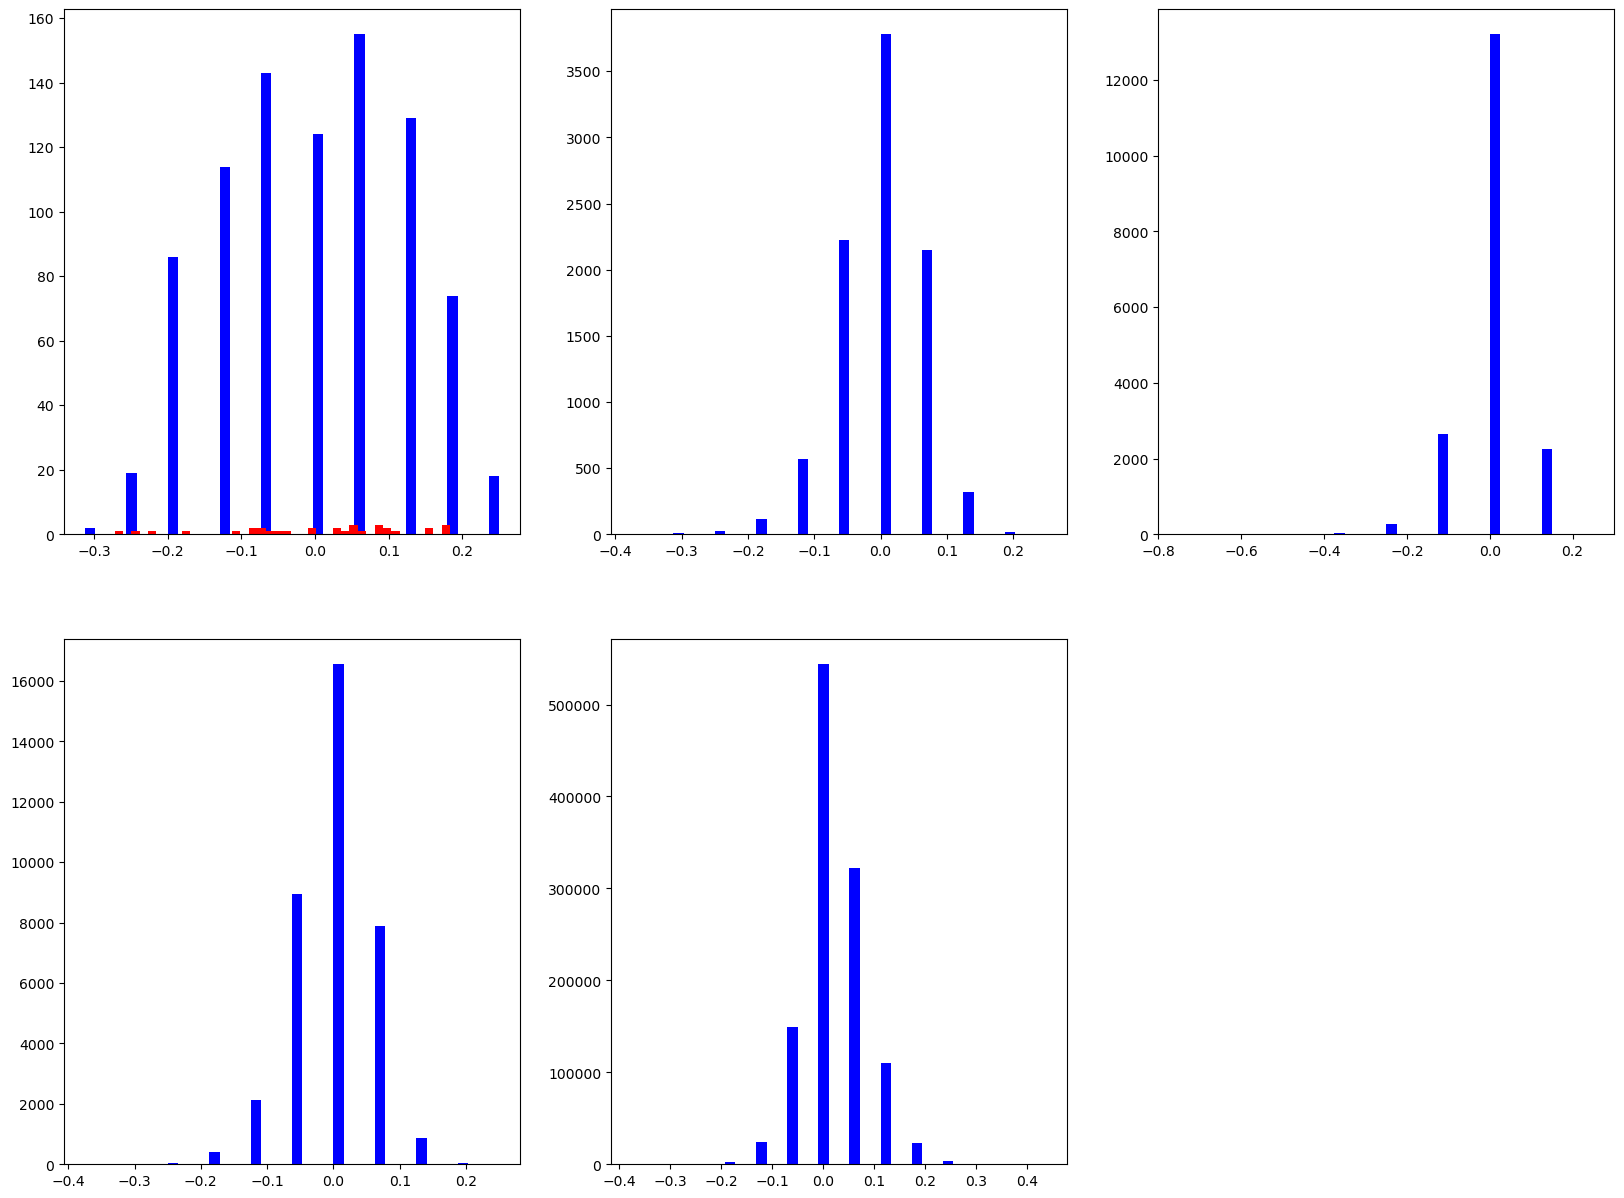

In [6]:
import matplotlib.pyplot as plt
w_1 = keras_model.get_model_weights_by_layer(dense=True)
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
ax = ax.flat
for i in range(5):
    weight, bias = w_1[i]
    weight = weight.detach().numpy().flatten()
    ax[i].hist(weight, bins=40, color='blue');
    bias = bias.detach().numpy().flatten() if bias is not None else None
    ax[i].hist(bias, bins=40, color='red') if bias is not None else None
fig.delaxes(ax[-1])

In [7]:
keras_model = keras_model.load_model_from_path()

offsets = fixed_bitwidth.find_offsets_for_model_weights(keras_model, 0, 8)
w_quant_params = {i: [8, j] for i, j in offsets.items()}
keras_model = fxp_quantize.fix_weights_quantization(keras_model, w_quant_params)

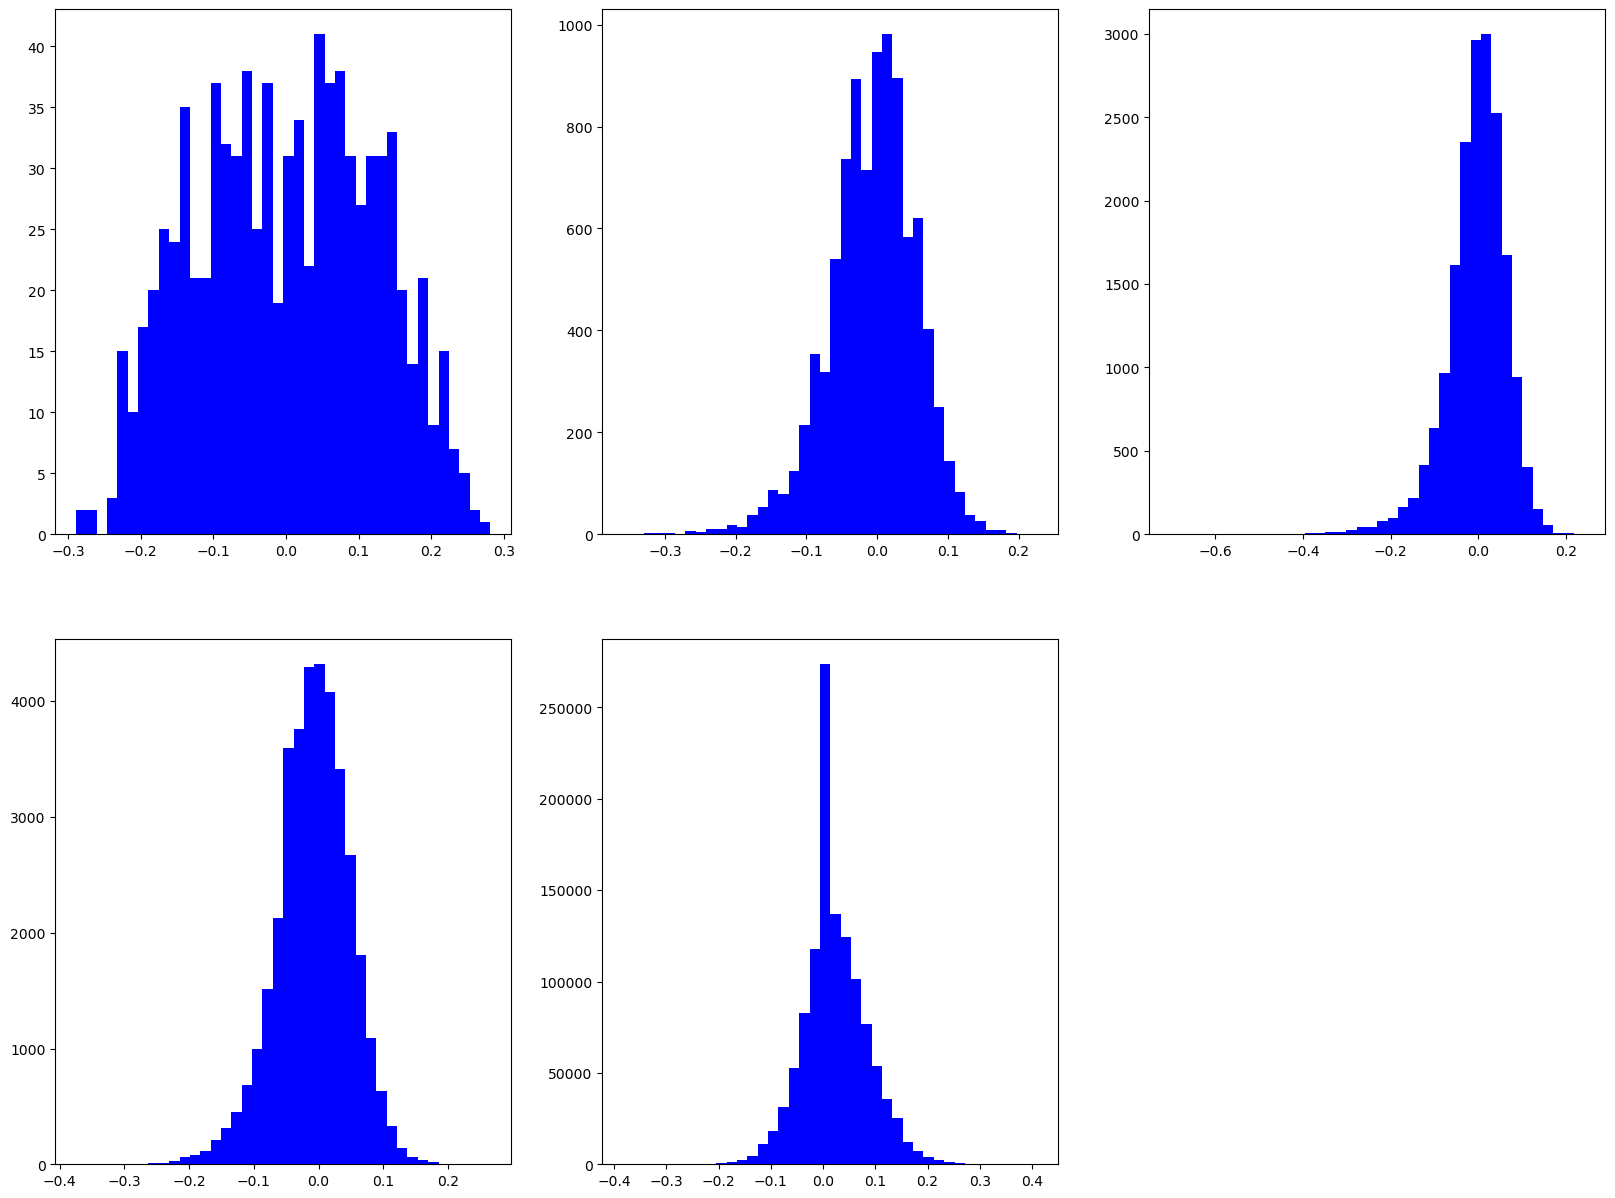

In [8]:
w_2 = keras_model.get_model_weights_by_layer(dense=True)
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
ax = ax.flat
for i in range(5):
    weight, bias = w_2[i]
    weight = weight.detach().numpy().flatten()
    ax[i].hist(weight, bins=40, color='blue');
    bias = bias.detach().numpy().flatten() if bias is not None else None
    # ax[i].hist(bias, bins=40, color='red') if bias is not None else None
fig.delaxes(ax[-1])

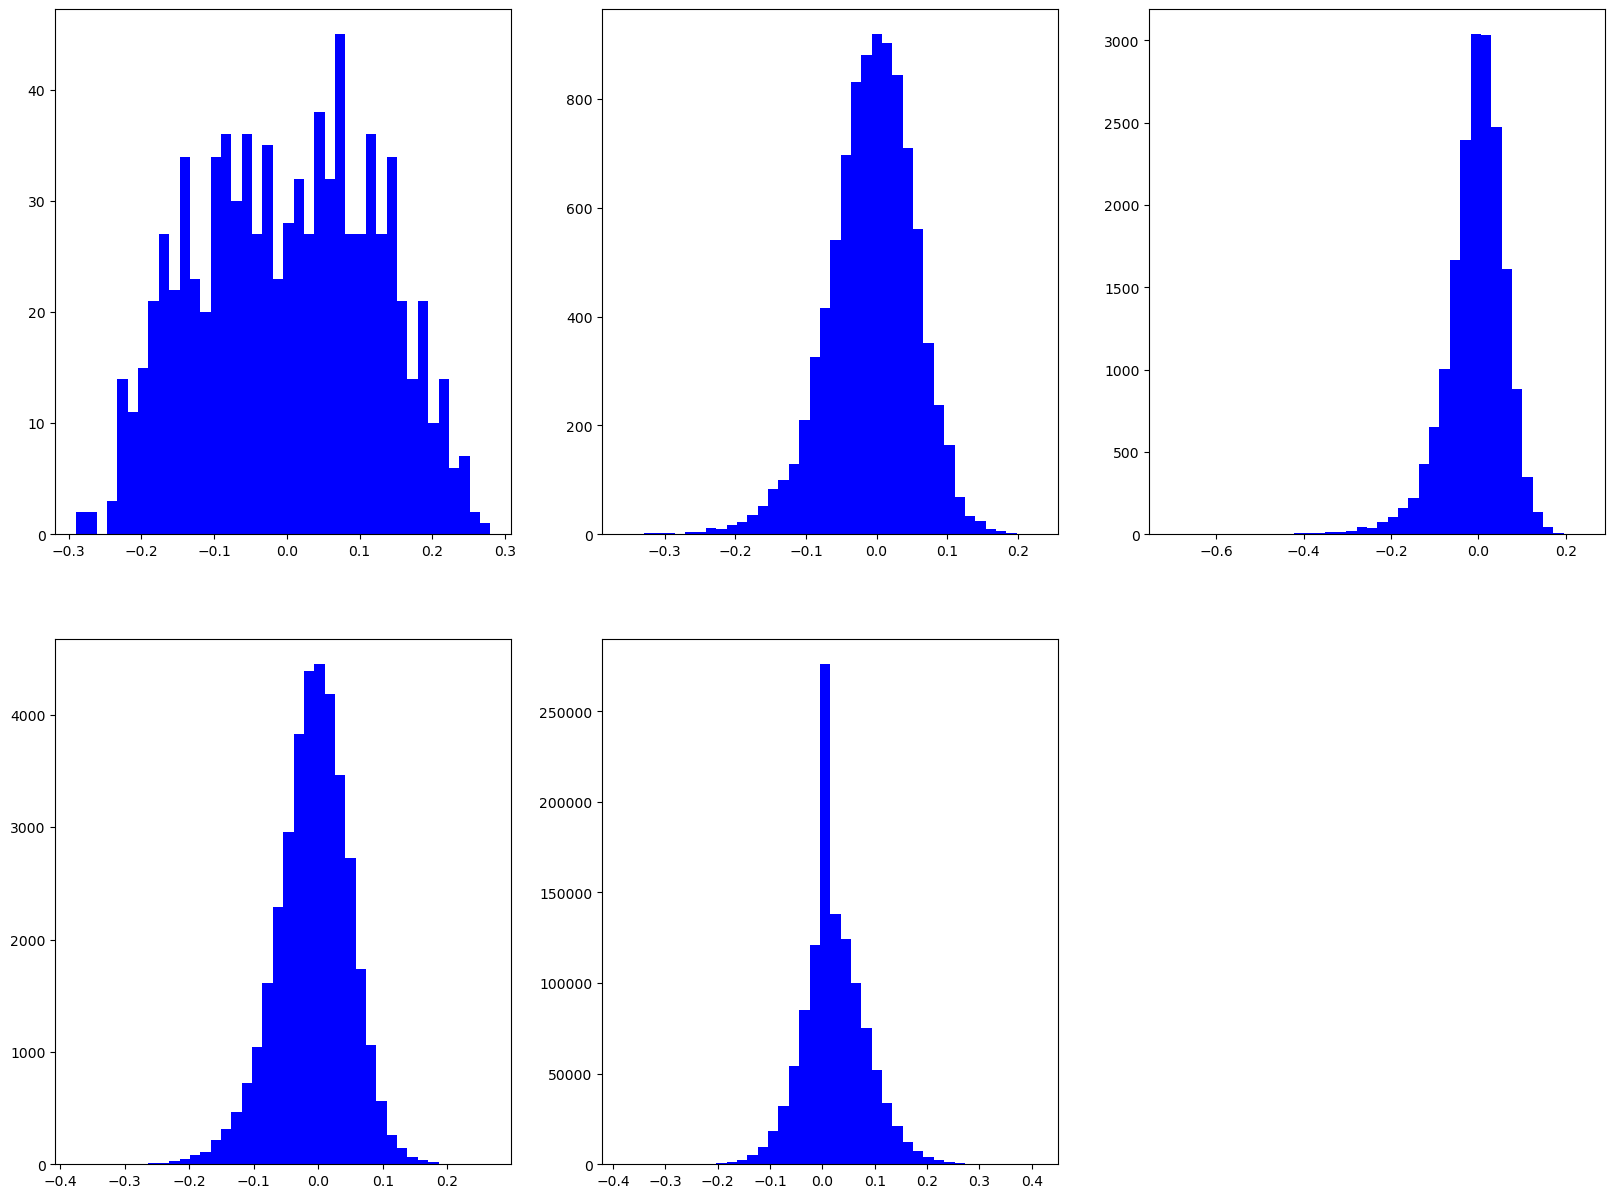

In [9]:
keras_model.load_model_from_path()
w_3 = keras_model.get_model_weights_by_layer(dense=True)
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
ax = ax.flat
for i in range(5):
    weight, bias = w_3[i]
    weight = weight.detach().numpy().flatten()
    ax[i].hist(weight, bins=40, color='blue');
    # bias = bias.detach().numpy().flatten() if bias is not None else None
    # ax[i].hist(bias, bins=40, color='red') if bias is not None else None
fig.delaxes(ax[-1])

In [10]:
# Compare max values to ensure no clipping occurs
for i in range(5):
    print(torch.max(torch.abs(w_1[i][0])), torch.max(torch.abs(w_2[i][0])), torch.max(torch.abs(w_3[i][0])))

tensor(0.2899) tensor(0.2899) tensor(0.2899)
tensor(0.3592) tensor(0.3592) tensor(0.3592)
tensor(0.7055) tensor(0.7055) tensor(0.7055)
tensor(0.3757) tensor(0.3757) tensor(0.3757)
tensor(0.4109) tensor(0.4109) tensor(0.4109)


In [11]:
# # Vary the bitwidth but keep it fixed across all layers
# accuracy = []
# for i in range(2, 12):
#     keras_model = keras_model.load_model_from_path()
#     original_acc = keras_model.evaluate_accuracy()
#     _, _, _, acc = fixed_bitwidth.evaluate_quantized_weights(keras_model, original_acc, bitwidth=i)
#     accuracy.append(acc)

In [12]:
# w = [w_b['weights'] for bit, w_b, in enumerate(accuracy, 2)]
# b = [w_b['biases'] for bit, w_b, in enumerate(accuracy, 2)]
# w.reverse()
# b.reverse()
# plt.figure(figsize=(10, 6))
# plt.subplot(1, 2, 1)
# plt.title('Biases')
# plt.plot(np.arange(2, 12, 1), b, 'o-'); # Bias
# plt.plot(np.arange(2, 12, 1), np.ones_like(np.arange(2, 12, 1))*10, '--', color='red');
# plt.subplot(1, 2, 2)
# plt.title('Weights')
# plt.plot(np.arange(2, 12, 1), w, 'o-'); # Weight
# plt.plot(np.arange(2, 12, 1), np.ones_like(np.arange(2, 12, 1))*10, '--', color='red');


## Activations

In [13]:
from torch.utils.data import DataLoader
for imgs, labels in DataLoader(testset):
    print(imgs.shape, labels.shape)
    break

torch.Size([1, 3, 32, 32]) torch.Size([1])


In [14]:
original_acc = keras_model.evaluate_accuracy()
keras_model = keras_model.load_model_from_path()
model_obj, w_quant_params, b_quant_params, acc_drop = fixed_bitwidth.evaluate_quantized_weights(keras_model, original_acc, bitwidth=8)
from keras_cnn import PytorchCNN


Calculating fractional offsets for weights of the network
Original network's accuracy: 0.8424999713897705


Quantized network's accuracy: 0.8416999578475952
Bandwidth: 8
Accuracy drop: 0.095 %
Calculating fractional offsets for the biases of the network


Quantized network's accuracy: 0.8413999676704407
Accuracy drop: 0.131 %


In [15]:
fixed_bitwidth.evaluate_quantized_activations(model_obj.model, name, testset, 
                                              original_acc=original_acc,
                                              bitwidth=8, num_images = 500)

{}
Original network's accuracy: 0.8424999713897705


Quantized network's accuracy: 0.09789999574422836
Accuracy drop: 88.380 %


(<model_data.Model at 0x1f749871c30>, {}, {'activations': 88.37982206898658})